In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import Delaunay
from form_factor import *

In [2]:
# ---------------------------
# Bifrustum Vertex Generator
# ---------------------------
def bifrustum_verts(n, a, c, t):
    """
    Generate the 3D coordinates of a bifrustum shape (truncated bipyramid).

    Parameters:
    - n: int
        Number of sides in the base polygon (e.g., 5 for a pentagon).
    - a: float
        Circumradius of the base polygon.
    - c: float
        Half-height from center to apex (before truncation).
    - t: float
        Truncation ratio:
          t = 0 → sharp bipyramid,
          t = 1 → fully truncated to zero height.

    Returns:
    - verts: (3n, 3) np.ndarray
        Coordinates of vertices: base (z=0), upper (z=+), and lower (z=-).
    """
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)

    base = np.stack([a * np.cos(angles), a * np.sin(angles), np.zeros(n)], axis=1)
    a_t = a * t
    z_up = c * (1 - t)
    up = np.stack([a_t * np.cos(angles), a_t * np.sin(angles), np.full(n, z_up)], axis=1)
    down = np.stack([a_t * np.cos(angles), a_t * np.sin(angles), np.full(n, -z_up)], axis=1)

    verts = np.vstack([base, up, down])
    return verts

# ---------------------------
# Bifrustum Face Definition
# ---------------------------
def bifrustum_faces(n):
    """
    Generate polygonal face indices for a bifrustum.

    Parameters:
    - n: int
        Number of vertices in each polygon layer.

    Returns:
    - faces: list of lists of int
        Face vertex indices (quads and caps).
    """
    base = list(range(n))
    up = list(range(n, 2 * n))
    down = list(range(2 * n, 3 * n))

    faces = [up, down]  # Top and bottom caps

    for i in range(n):
        j = (i + 1) % n
        faces.append([base[i], base[j], up[j], up[i]])      # upper side
        faces.append([base[i], base[j], down[j], down[i]])  # lower side

    return faces

# ---------------------------
# Rod Vertex Generator
# ---------------------------
def rod_verts(n, r, L):
    """
    Generate the 3D coordinates of a right prism rod with n-gon base.

    Parameters:
    - n: int
        Number of sides of the regular polygon cross-section.
    - r: float
        Circumradius of the base polygon.
    - L: float
        Total length of the rod along the z-axis.

    Returns:
    - verts: (2n, 3) np.ndarray
        Array of 3D coordinates: upper and lower polygon vertices.
    """
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)

    # Upper face (z = +L/2)
    up = np.stack([r * np.cos(angles), r * np.sin(angles), np.full(n, L / 2)], axis=1)

    # Lower face (z = -L/2)
    down = np.stack([r * np.cos(angles), r * np.sin(angles), np.full(n, -L / 2)], axis=1)

    # Concatenate
    verts = np.vstack([up, down])
    return verts

# ---------------------------
# Rod Face Definition
# ---------------------------
def rod_faces(n):
    """
    Generate polygonal face indices for an n-gon-based rod (prism).

    Parameters:
    - n: int
        Number of polygon vertices on each face.

    Returns:
    - faces: list of lists of int
        Polygon faces (top, bottom, and lateral quads).
    """
    up = list(range(n))
    down = list(range(n, 2 * n))

    faces = [up, down]  # Top and bottom polygon caps

    # Lateral sides as quads
    for i in range(n):
        j = (i + 1) % n
        faces.append([i, i + n, j + n, j])

    return faces

# ---------------------------
# Cube (111) Direction Vertices
# ---------------------------
def cube_111_vertices(scale=1.0):
    """
    Generate vertices along (111)-type directions of a cube.

    Parameters:
    - scale: float
        Scale factor (distance from origin to vertex).

    Returns:
    - verts: (8, 3) np.ndarray
        Array of vertices along ±(1,1,1) directions.
    """
    directions = list(product([-1, 1], repeat=3))
    return np.array(directions, dtype=float) * scale


In [3]:
# ================================================================
# SECTION: Mesh Visualization and Analysis
# ================================================================

# ---------------------------
# Plot Tetrahedra with Center Offset
# ---------------------------
def plot_tetrahedra_center_offset(verts, tetrahedra, offset=0.2, noaxis=False):
    """
    Visualize tetrahedra with slight offset from their center to avoid overlap.

    Parameters:
    - verts: (N, 3) array of vertex coordinates
    - tetrahedra: (M, 4) array of tetrahedron vertex indices
    - offset: float
        Multiplier applied to center of each tetrahedron for visualization.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for tet in tetrahedra:
        tet_verts = verts[tet]
        center = tet_verts.mean(axis=0)
        shifted = tet_verts + offset * center

        faces = [
            [shifted[0], shifted[1], shifted[2]],
            [shifted[0], shifted[1], shifted[3]],
            [shifted[0], shifted[2], shifted[3]],
            [shifted[1], shifted[2], shifted[3]],
        ]
        poly = Poly3DCollection(faces, alpha=0.5, edgecolor='k')  # For reproducibility
        poly.set_facecolor(np.random.rand(3,))
        ax.add_collection3d(poly)

    all_shifted = np.vstack([verts[tet] + offset * verts[tet].mean(axis=0) for tet in tetrahedra])
    max_range = (all_shifted.max(axis=0) - all_shifted.min(axis=0)).max() / 2.0
    mid = all_shifted.mean(axis=0)

    for axis, m in zip([ax.set_xlim, ax.set_ylim, ax.set_zlim], mid):
        axis(m - max_range, m + max_range)

    ax.set_box_aspect([1, 1, 1])
    
    if noaxis:
        ax.set_axis_off()
        
    plt.tight_layout()
    plt.show()

# ---------------------------
# Compute Volume of Tetrahedra
# ---------------------------
def compute_tetrahedra_volumes(verts, tetrahedra):
    """
    Compute volume of each tetrahedron.

    Parameters:
    - verts: (N, 3)
    - tetrahedra: (M, 4)

    Returns:
    - volumes: (M,) np.ndarray of positive volumes.
    """
    v0 = verts[tetrahedra[:, 0]]
    v1 = verts[tetrahedra[:, 1]]
    v2 = verts[tetrahedra[:, 2]]
    v3 = verts[tetrahedra[:, 3]]

    cross = np.cross(v1 - v0, v2 - v0)
    dot = np.einsum('ij,ij->i', cross, v3 - v0)
    volumes = np.abs(dot) / 6.0
    return volumes

# ---------------------------
# Fix Tetrahedron Orientations
# ---------------------------
def fix_tetrahedron_orientations(verts, tetrahedra):
    """
    Ensure all tetrahedra are right-handed (positive volume).

    Parameters:
    - verts: (N, 3)
    - tetrahedra: (M, 4)

    Returns:
    - corrected_tetrahedra: (M, 4)
    """
    corrected = tetrahedra.copy()

    for i, tet in enumerate(tetrahedra):
        v0, v1, v2, v3 = verts[tet]
        signed_vol = np.dot(np.cross(v1 - v0, v2 - v0), v3 - v0)
        if signed_vol < 0:
            corrected[i] = [tet[0], tet[2], tet[1], tet[3]]  # Swap to fix parity

    return corrected

## Bipyramid

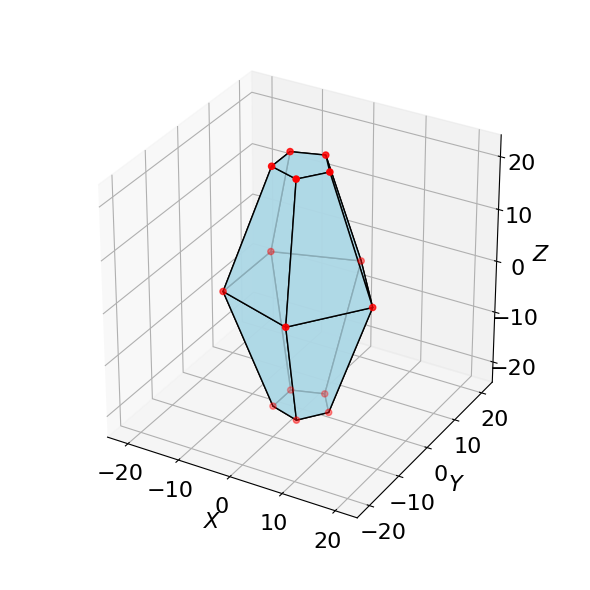

In [4]:
# Parameters
n = 5
a = 13.35
c = 37.4
t = 10.2 / 26.7

verts = bifrustum_verts(n, a, c, t)
faces = bifrustum_faces(n)

from scipy.spatial.transform import Rotation
# # Apply a random rotation
# rotation = Rotation.random()
# verts = rotation.apply(verts)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

poly3d = [[verts[idx] for idx in face] for face in faces]
ax.add_collection3d(Poly3DCollection(poly3d, facecolors='lightblue', linewidths=1, edgecolors='k', alpha=0.8))

ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='r', s=20)

# Set equal aspect
max_range = (verts.max(axis=0) - verts.min(axis=0)).max() / 2.0
mid = verts.mean(axis=0)
for axis, m in zip([ax.set_xlim, ax.set_ylim, ax.set_zlim], mid):
    axis(m - max_range, m + max_range)

ax.tick_params(which='major', labelsize=16)
ax.set_xlabel('$X$', fontsize=16)
ax.set_ylabel('$Y$', fontsize=16)
ax.set_zlabel('$Z$', fontsize=16)
ax.set_box_aspect([1,1,1], zoom=0.85)

plt.tight_layout()
plt.show()


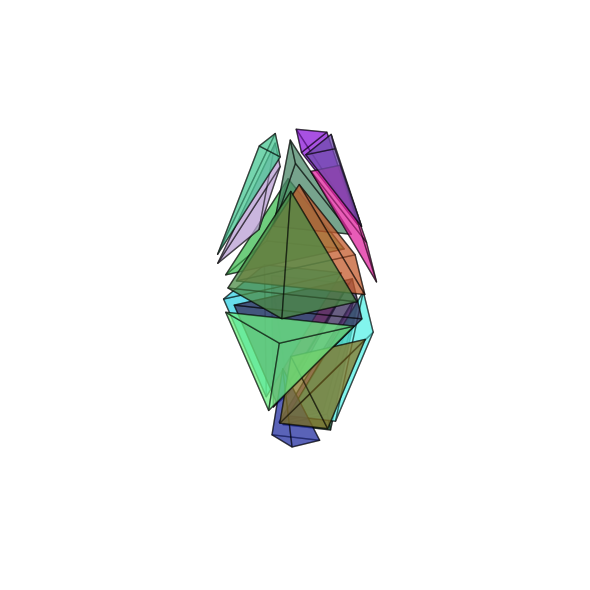

In [5]:
# Dissect the bifrustum into tetrahedra
delaunay = Delaunay(verts)
tetrahedra = delaunay.simplices

# Compute volumes of all tetrahedra
tetra_volumes = compute_tetrahedra_volumes(verts, tetrahedra)

# Filter out near-zero volume tetrahedra (threshold = 1e-6)
volume_threshold = 1e-6
valid_indices = np.where(tetra_volumes > volume_threshold)[0]

# Filter tetrahedra and volumes
filtered_tetrahedra = tetrahedra[valid_indices]
filtered_volumes = tetra_volumes[valid_indices]

total_volume = np.sum(filtered_volumes)

# Apply orientation correction to the tetrahedral mesh
tetrahedra_fixed = fix_tetrahedron_orientations(verts, filtered_tetrahedra)

# Visualize the result
plot_tetrahedra_center_offset(verts, tetrahedra_fixed, offset=0.5, noaxis=True)

In [6]:
# Grid resolution
n_grid = 100
qx = np.linspace(-1, 1, n_grid)
qy = np.linspace(-1, 1, n_grid)
qz = np.linspace(-1, 1, n_grid)

# Generate 2D q-grids with correct axis indexing
q_grid_xy = np.meshgrid(qx, qy, [0], indexing='ij')
q_grid_xz = np.meshgrid(qx, [0], qz, indexing='ij')
q_grid_yz = np.meshgrid([0], qy, qz, indexing='ij')

# Evaluate scattering intensity for XY, XZ, and YZ planes
I_q_grid_flat_xy = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_xy)
I_q_xy = I_q_grid_flat_xy.reshape((n_grid, n_grid)) / total_volume**2

I_q_grid_flat_xz = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_xz)
I_q_xz = I_q_grid_flat_xz.reshape((n_grid, n_grid)) / total_volume**2

I_q_grid_flat_yz = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_yz)
I_q_yz = I_q_grid_flat_yz.reshape((n_grid, n_grid)) / total_volume**2

# Compute full 3D scattering function
q_range = 1.0
n_q = 100
qx_3d = np.linspace(-q_range, q_range, n_q)
qy_3d = np.linspace(-q_range, q_range, n_q)
qz_3d = np.linspace(-q_range, q_range, n_q)

q_grid_3d = np.meshgrid(qx_3d, qy_3d, qz_3d, indexing='ij')
I_q_flat = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_3d)
I_q_3d = I_q_flat.reshape((n_q, n_q, n_q)) / total_volume**2

# Compute |Q| for radial averaging
Q_mag = np.sqrt(q_grid_3d[0]**2 + q_grid_3d[1]**2 + q_grid_3d[2]**2).flatten()
I_vals = I_q_3d.flatten()

# Bin into radial shells
Q_bins = np.linspace(0, q_range * np.sqrt(3), 100)
Q_centers = 0.5 * (Q_bins[:-1] + Q_bins[1:])
I_avg = np.zeros_like(Q_centers)
counts = np.zeros_like(Q_centers)

for i in range(len(Q_centers)):
    mask = (Q_mag >= Q_bins[i]) & (Q_mag < Q_bins[i + 1])
    if np.any(mask):
        I_avg[i] = I_vals[mask].mean()
        counts[i] = np.sum(mask)

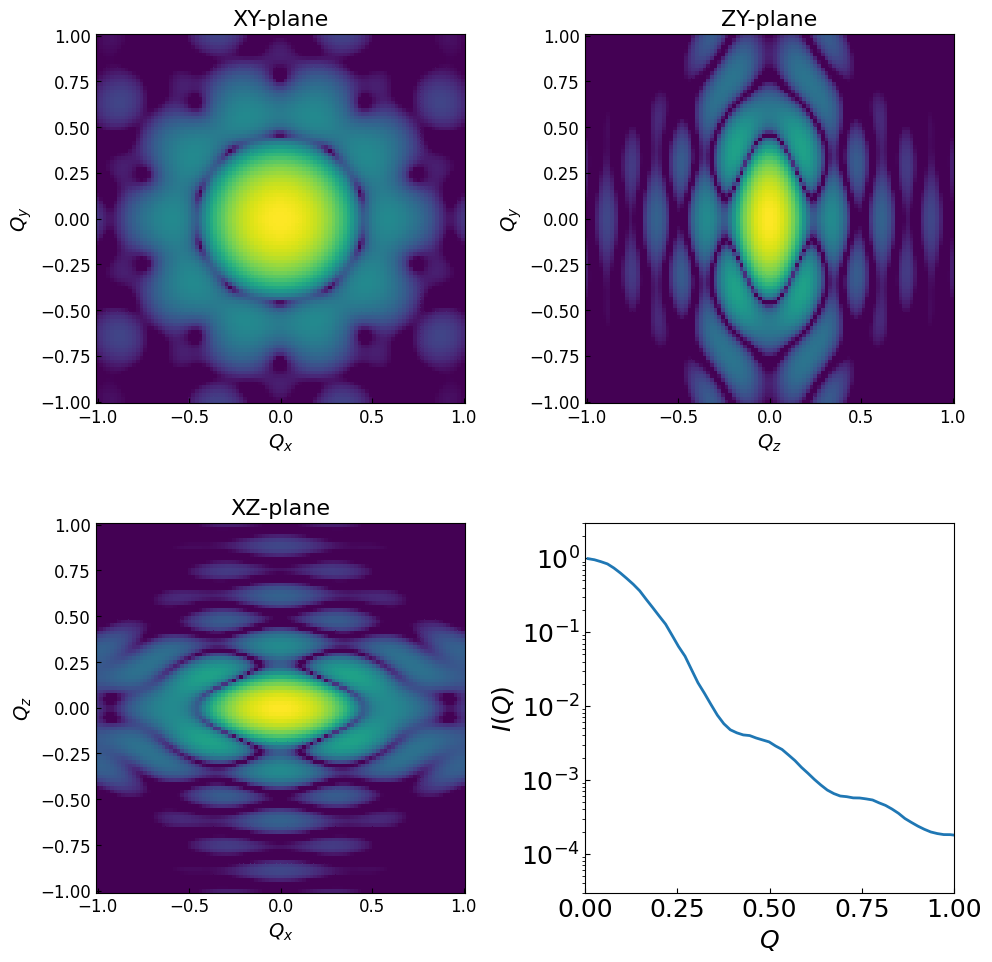

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Panel (0, 0) - XY-plane
qx_plot, qy_plot = np.meshgrid(qx, qy, indexing='ij')
axes[0, 0].pcolor(qx_plot, qy_plot, np.log(I_q_xy), cmap='viridis', vmax=0, vmin=-10)
axes[0, 0].set_title('XY-plane', fontsize=16)
axes[0, 0].set_xlabel('$Q_x$', fontsize=14)
axes[0, 0].set_ylabel('$Q_y$', fontsize=14)
axes[0, 0].set_aspect('equal')
axes[0, 0].tick_params(direction='in', labelsize=12)

# Panel (0, 1) - ZY-plane (swapped from original YZ)
qz_plot, qy_plot = np.meshgrid(qz, qy, indexing='ij')
axes[0, 1].pcolor(qz_plot, qy_plot, np.log(I_q_yz.T), cmap='viridis', vmax=0, vmin=-10)
axes[0, 1].set_title('ZY-plane', fontsize=16)
axes[0, 1].set_xlabel('$Q_z$', fontsize=14)
axes[0, 1].set_ylabel('$Q_y$', fontsize=14)
axes[0, 1].set_aspect('equal')
axes[0, 1].tick_params(direction='in', labelsize=12)

# Panel (1, 0) - XZ-plane
qx_plot, qz_plot = np.meshgrid(qx, qz, indexing='ij')
axes[1, 0].pcolor(qx_plot, qz_plot, np.log(I_q_xz), cmap='viridis', vmax=0, vmin=-10)
axes[1, 0].set_title('XZ-plane', fontsize=16)
axes[1, 0].set_xlabel('$Q_x$', fontsize=14)
axes[1, 0].set_ylabel('$Q_z$', fontsize=14)
axes[1, 0].set_aspect('equal')
axes[1, 0].tick_params(direction='in', labelsize=12)

# Panel (1, 1) - Radial average
axes[1, 1].plot(Q_centers, I_avg, lw=2)
axes[1, 1].set_yscale('log')
axes[1, 1].set_title(' ', fontsize=18)
axes[1, 1].tick_params(direction='in', labelsize=14)
axes[1, 1].set_xlabel('$Q$', fontsize=18)
axes[1, 1].set_ylabel('$I(Q)$', fontsize=18)
axes[1, 1].set_xlim(0, np.max(qx))
axes[1, 1].set_ylim(3e-5, 3e0)
axes[1, 1].set_aspect(np.max(qx)/5)
axes[1, 1].tick_params(direction='in', labelsize=18)

plt.tight_layout()
plt.show()

## Rod

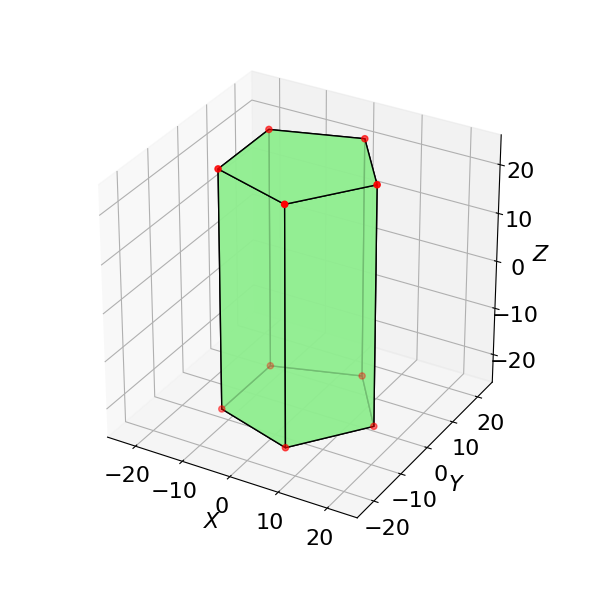

In [8]:
## Example usage
n = 5        # number of polygon sides
r = 15    # circumradius
L = 50     # rod length

verts = rod_verts(n, r, L)
faces = rod_faces(n)

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

poly3d = [[verts[idx] for idx in face] for face in faces]
ax.add_collection3d(Poly3DCollection(poly3d, facecolors='lightgreen', linewidths=1, edgecolors='k', alpha=0.8))
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], color='r', s=20)

# Set equal aspect
max_range = (verts.max(axis=0) - verts.min(axis=0)).max() / 2.0
mid = verts.mean(axis=0)
for axis, m in zip([ax.set_xlim, ax.set_ylim, ax.set_zlim], mid):
    axis(m - max_range, m + max_range)

ax.tick_params(which='major', labelsize=16)
ax.set_xlabel('$X$', fontsize=16)
ax.set_ylabel('$Y$', fontsize=16)
ax.set_zlabel('$Z$', fontsize=16)
ax.set_box_aspect([1,1,1], zoom=0.85)

plt.tight_layout()
plt.show()

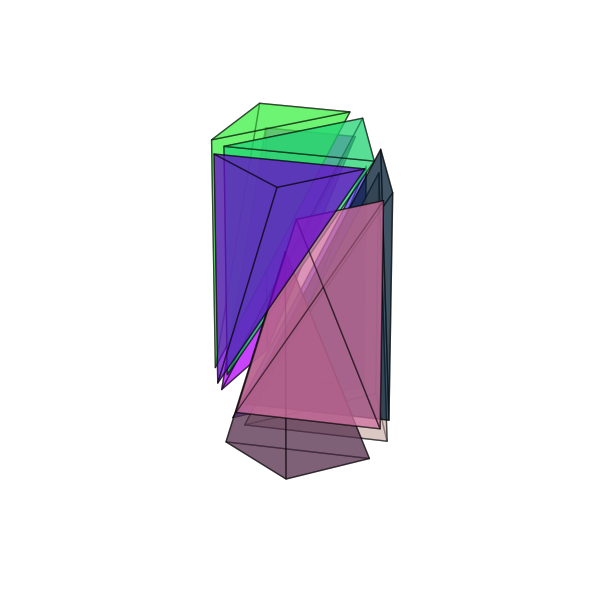

In [9]:
# Dissect the bifrustum into tetrahedra
delaunay = Delaunay(verts)
tetrahedra = delaunay.simplices

# Compute volumes of all tetrahedra
tetra_volumes = compute_tetrahedra_volumes(verts, tetrahedra)

# Filter out near-zero volume tetrahedra (threshold = 1e-6)
volume_threshold = 1e-6
valid_indices = np.where(tetra_volumes > volume_threshold)[0]

# Filter tetrahedra and volumes
filtered_tetrahedra = tetrahedra[valid_indices]
filtered_volumes = tetra_volumes[valid_indices]

total_volume = np.sum(filtered_volumes)

# Apply orientation correction to the tetrahedral mesh
tetrahedra_fixed = fix_tetrahedron_orientations(verts, filtered_tetrahedra)

# Visualize the result
plot_tetrahedra_center_offset(verts, tetrahedra_fixed, offset=0.5, noaxis=True)

In [10]:
# Grid resolution
n_grid = 100
qx = np.linspace(-1, 1, n_grid)
qy = np.linspace(-1, 1, n_grid)
qz = np.linspace(-1, 1, n_grid)

# Generate 2D q-grids with correct axis indexing
q_grid_xy = np.meshgrid(qx, qy, [0], indexing='ij')
q_grid_xz = np.meshgrid(qx, [0], qz, indexing='ij')
q_grid_yz = np.meshgrid([0], qy, qz, indexing='ij')

# Evaluate scattering intensity for XY, XZ, and YZ planes
I_q_grid_flat_xy = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_xy)
I_q_xy = I_q_grid_flat_xy.reshape((n_grid, n_grid)) / total_volume**2

I_q_grid_flat_xz = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_xz)
I_q_xz = I_q_grid_flat_xz.reshape((n_grid, n_grid)) / total_volume**2

I_q_grid_flat_yz = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_yz)
I_q_yz = I_q_grid_flat_yz.reshape((n_grid, n_grid)) / total_volume**2

# Compute full 3D scattering function
q_range = 1.0
n_q = 100
qx_3d = np.linspace(-q_range, q_range, n_q)
qy_3d = np.linspace(-q_range, q_range, n_q)
qz_3d = np.linspace(-q_range, q_range, n_q)

q_grid_3d = np.meshgrid(qx_3d, qy_3d, qz_3d, indexing='ij')
I_q_flat = scattering_function_adaptive(verts, tetrahedra_fixed, q_grid_3d)
I_q_3d = I_q_flat.reshape((n_q, n_q, n_q)) / total_volume**2

# Compute |Q| for radial averaging
Q_mag = np.sqrt(q_grid_3d[0]**2 + q_grid_3d[1]**2 + q_grid_3d[2]**2).flatten()
I_vals = I_q_3d.flatten()

# Bin into radial shells
Q_bins = np.linspace(0, q_range * np.sqrt(3), 100)
Q_centers = 0.5 * (Q_bins[:-1] + Q_bins[1:])
I_avg = np.zeros_like(Q_centers)
counts = np.zeros_like(Q_centers)

for i in range(len(Q_centers)):
    mask = (Q_mag >= Q_bins[i]) & (Q_mag < Q_bins[i + 1])
    if np.any(mask):
        I_avg[i] = I_vals[mask].mean()
        counts[i] = np.sum(mask)

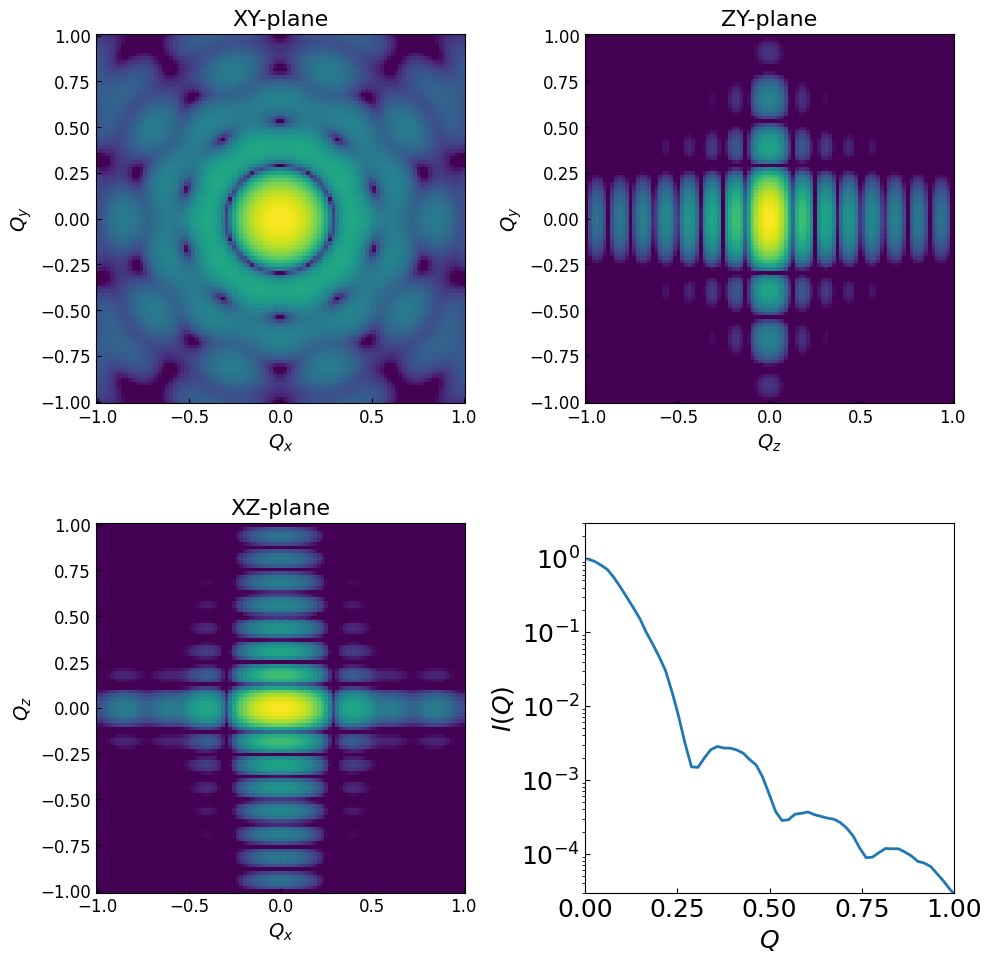

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Panel (0, 0) - XY-plane
qx_plot, qy_plot = np.meshgrid(qx, qy, indexing='ij')
axes[0, 0].pcolor(qx_plot, qy_plot, np.log(I_q_xy), cmap='viridis', vmax=0, vmin=-10)
axes[0, 0].set_title('XY-plane', fontsize=16)
axes[0, 0].set_xlabel('$Q_x$', fontsize=14)
axes[0, 0].set_ylabel('$Q_y$', fontsize=14)
axes[0, 0].set_aspect('equal')
axes[0, 0].tick_params(direction='in', labelsize=12)

# Panel (0, 1) - ZY-plane (swapped from original YZ)
qz_plot, qy_plot = np.meshgrid(qz, qy, indexing='ij')
axes[0, 1].pcolor(qz_plot, qy_plot, np.log(I_q_yz.T), cmap='viridis', vmax=0, vmin=-10)
axes[0, 1].set_title('ZY-plane', fontsize=16)
axes[0, 1].set_xlabel('$Q_z$', fontsize=14)
axes[0, 1].set_ylabel('$Q_y$', fontsize=14)
axes[0, 1].set_aspect('equal')
axes[0, 1].tick_params(direction='in', labelsize=12)

# Panel (1, 0) - XZ-plane
qx_plot, qz_plot = np.meshgrid(qx, qz, indexing='ij')
axes[1, 0].pcolor(qx_plot, qz_plot, np.log(I_q_xz), cmap='viridis', vmax=0, vmin=-10)
axes[1, 0].set_title('XZ-plane', fontsize=16)
axes[1, 0].set_xlabel('$Q_x$', fontsize=14)
axes[1, 0].set_ylabel('$Q_z$', fontsize=14)
axes[1, 0].set_aspect('equal')
axes[1, 0].tick_params(direction='in', labelsize=12)

# Panel (1, 1) - Radial average
axes[1, 1].plot(Q_centers, I_avg, lw=2)
axes[1, 1].set_yscale('log')
axes[1, 1].set_title(' ', fontsize=18)
axes[1, 1].tick_params(direction='in', labelsize=14)
axes[1, 1].set_xlabel('$Q$', fontsize=18)
axes[1, 1].set_ylabel('$I(Q)$', fontsize=18)
axes[1, 1].set_xlim(0, np.max(qx))
axes[1, 1].set_ylim(3e-5, 3e0)
axes[1, 1].set_aspect(np.max(qx)/5)
axes[1, 1].tick_params(direction='in', labelsize=18)

plt.tight_layout()
plt.show()